In [1]:
import os
import numpy as np
import jax.numpy as jnp
import jax.random as random
from scipy.stats import gaussian_kde
from rsnl.metrics import plot_and_save_coverage
from rsnl.examples.sir import calculate_summary_statistics, true_dgp, assumed_dgp
import matplotlib.pyplot as plt
import pickle as pkl
import arviz as az
import matplotlib.colors as mcolors

/Users/ryankelly/python_projects/rsnl/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'cm'

In [3]:
seed = 4
rng_key = random.PRNGKey(seed)
rng_key, sub_key1, sub_key2 = random.split(rng_key, 3)
true_params = jnp.array([0.1, 0.15])
x_obs = true_dgp(sub_key2, *true_params)
x_obs = calculate_summary_statistics(x_obs)
print('x_obs', x_obs)


beta: 0.15000000596046448, gamma: 0.10000000149011612
Cache cleared
Process uses 254.28515625 MB memory.
summaries:  [ 9.677275    8.457292   11.156181    4.75359     4.762174    0.99569786]
x_obs [ 9.677275    8.457292   11.156181    4.75359     4.762174    0.99569786]


In [4]:
for i in range(10):
    rng_key, sub_key1, sub_key2 = random.split(rng_key, 3)
    print(calculate_summary_statistics(assumed_dgp(sub_key1, *true_params)))

beta: 0.15000000596046448, gamma: 0.10000000149011612
Cache cleared
Process uses 263.9765625 MB memory.
summaries:  [ 9.677559    8.435976   11.06161     4.744932    4.762174    0.99969244]
[ 9.677559    8.435976   11.06161     4.744932    4.762174    0.99969244]
beta: 0.15000000596046448, gamma: 0.10000000149011612
Cache cleared
Process uses 263.00390625 MB memory.
summaries:  [ 9.677349   8.435535  11.061535   4.744932   4.762174   0.9996923]
[ 9.677349   8.435535  11.061535   4.744932   4.762174   0.9996923]
beta: 0.15000000596046448, gamma: 0.10000000149011612
Cache cleared
Process uses 264.47265625 MB memory.
summaries:  [ 9.677434   8.435539  11.061562   4.744932   4.762174   0.9996924]
[ 9.677434   8.435539  11.061562   4.744932   4.762174   0.9996924]
beta: 0.15000000596046448, gamma: 0.10000000149011612
Cache cleared
Process uses 266.53125 MB memory.
summaries:  [ 9.677446    8.43657    11.061515    4.744932    4.762174    0.99969244]
[ 9.677446    8.43657    11.061515    4.74

In [5]:
with open("../res/sir/tmp_rsnl/rsnl/seed_4/thetas.pkl", "rb") as f:
    theta_draws_rsnl = jnp.array(pkl.load(f))

thetas_rsnl = jnp.concatenate(theta_draws_rsnl, axis=0)
thetas_rsnl = jnp.squeeze(thetas_rsnl)

with open("../res/sir/tmp_rsnl/rsnl/seed_4/adj_params.pkl", "rb") as f:
    adj_params = jnp.array(pkl.load(f))

adj_params = jnp.concatenate(adj_params, axis=0)

with open("../res/sir/snl/seed_4/thetas.pkl", "rb") as f:
    theta_draws_snl = jnp.array(pkl.load(f))

thetas_snl = jnp.concatenate(theta_draws_snl, axis=0)
thetas_snl = jnp.squeeze(thetas_snl)

In [6]:
rsnl_theta_plot = {}
snl_correct_theta_plot = {}
snl_theta_plot = {}

for i in range(2):
    rsnl_theta_plot['theta' + str(i+1)] = thetas_rsnl[ :, i]
    snl_theta_plot['theta' + str(i+1)] = thetas_snl[:, i]

var_name_map = {}
reference_values = {}
labels = [r'$\eta$', r'$\beta$']
for ii, k in enumerate(rsnl_theta_plot):
    var_name_map[k] = labels[ii]
    reference_values[var_name_map[k]] = true_params[ii]  # why does ref_vals match labels and not data? ah well

/var/folders/_z/ms2f3nmn0bb7wk4py9_pz7900000gp/T/ipykernel_15783/1001080258.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


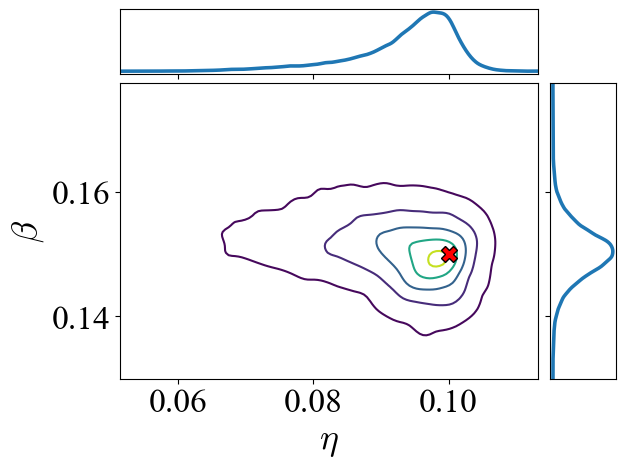

In [7]:
az.plot_pair(rsnl_theta_plot,
             kind='kde',
             reference_values=reference_values,
             marginals=True,
             labeller=az.labels.MapLabeller(var_name_map=var_name_map),
             reference_values_kwargs={'color': 'red', 'marker': 'X', 'markersize': 12},
             kde_kwargs={'hdi_probs': [0.05, 0.25, 0.5, 0.75, 0.95],
                         'contour_kwargs': {"colors":None, "cmap":plt.cm.viridis},
                         'contourf_kwargs': {"alpha":0}},
             textsize=24,
            )
plt.tight_layout()
plt.savefig("sir_theta_posterior.pdf", bbox_inches='tight')
# plt.xlabel(rf"$\theta_1$")

/var/folders/_z/ms2f3nmn0bb7wk4py9_pz7900000gp/T/ipykernel_15783/1436741592.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


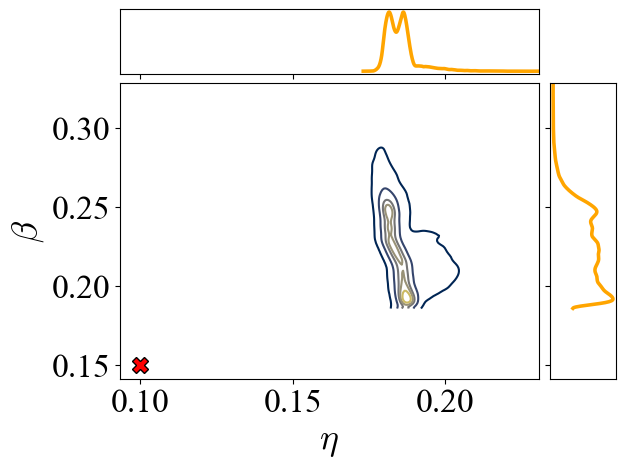

In [12]:
az.plot_pair(snl_theta_plot,
             kind='kde',
             reference_values=reference_values,
             marginals=True,
             labeller=az.labels.MapLabeller(var_name_map=var_name_map),
             reference_values_kwargs={'color': 'red', 'marker': 'X', 'markersize': 12},
             kde_kwargs={'hdi_probs': [0.05, 0.25, 0.5, 0.75, 0.95],
                         'contour_kwargs': {"colors":None, "cmap":plt.cm.cividis},
                         'contourf_kwargs': {"alpha":0}},
             marginal_kwargs={'color': 'orange'},
             textsize=24,
            )
plt.tight_layout()
plt.savefig("sir_snl_theta_posterior.pdf", bbox_inches='tight')
# plt.xlabel(rf"$\theta_1$")

In [9]:
# Set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'cm'


rng_key = random.PRNGKey(6)
prior_samples = random.laplace(rng_key, shape=(10000, 2))

for i in range(6):
    az.plot_dist(adj_params[:, i],
                 label='Posterior',
                 color='black')
    az.plot_dist(prior_samples[:, i],
                 color=mcolors.CSS4_COLORS['limegreen'],
                 plot_kwargs={'linestyle': 'dashed'},
                 label='Prior')

    plt.xlabel(f"$\gamma_{i+1}$", fontsize=25)
    plt.ylabel("Density", fontsize=25)
    plt.xlim([-10, 10])
    plt.xticks([-10, -5, 0, 5, 10], fontsize=25)
    plt.yticks(fontsize=25)
    plt.ylim(bottom=0)
    plt.legend(fontsize=25,
               loc='upper left',
               borderpad=0.1, labelspacing=0.1, handletextpad=0.1)

    plt.tight_layout()
    plt.savefig(f'sir_adj_param_{i+1}.pdf', bbox_inches='tight')
    plt.clf()

<Figure size 640x480 with 0 Axes>